# Supplementary Figure 7 - Compare GSAT in RCP8.5 and RCP4.5

In [1]:
import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt
from modelsDef import defModels
import glob,os

## Read GSAT files 

In [2]:
indir_hrcp85 = '/data/ysilvy/gsat/hist-rcp85/'
indir_rcp45 = '/data/ysilvy/gsat/rcp45/'

models = defModels()
imod=0
GSAT_h85_a_all = [0]*10
GSAT_45_a_all = [0]*10
DGSAT_all = [0]*10
model_names = ['']*10

for i,model in enumerate(models):
#i=1
    model=models[i]
    listmod = glob.glob(indir_rcp45+'GSAT*'+model['name']+'*.nc')
    if len(listmod)!=0:
        print('Working on', model['name'])
        
        # Read GSAT in hist+RCP8.5 file and in RCP4.5 file
        file_hrcp85 = glob.glob(indir_hrcp85+'GSAT*'+model['name']+'*.nc')[0]
        file_rcp45 = glob.glob(indir_rcp45+'GSAT*'+model['name']+'*.nc')[0]
        fhrcp85 = xr.open_dataset(file_hrcp85)
        frcp45 = xr.open_dataset(file_rcp45)
        if model['name'] != 'HadGEM2-ES':
            time = np.arange(1850,2101)
        else:
            time = np.arange(1859,2101)
        GSAT_h85 = xr.DataArray(fhrcp85.GSAT,dims=['time','members'],coords=[time,fhrcp85.members_name])
        GSAT_45 = xr.DataArray(frcp45.GSAT,dims=['time','members'],coords=[time[-95:],frcp45.members_name])

        # Reindex GSAT_h85 to fit the order of the RCP4.5 files (sorted order)
        GSAT_h85 = GSAT_h85.reindex({'time':GSAT_h85.time,'members':GSAT_45.members})

        # Compute anomaly
        GSAT_h85_a = GSAT_h85 - GSAT_h85.sel(time=slice(1850,1899)).mean(dim='time')
        GSAT_45_a = GSAT_45 - GSAT_h85.sel(time=slice(1850,1899)).mean(dim='time')

        # Delta GSAT = GSAT_rcp85 - GSAT-rcp45
        DGSAT = GSAT_h85_a.sel(time=slice(2006,2100)) - GSAT_45_a

        # Save into model list
        GSAT_h85_a_all[imod] = GSAT_h85_a
        GSAT_45_a_all[imod] = GSAT_45_a
        DGSAT_all[imod] = DGSAT
        model_names[imod] = model['name']
            
        imod=imod+1

Working on CanESM2
Working on CCSM4
Working on CESM1-CAM5
Working on CSIRO-Mk3-6-0
Working on GISS-E2-R
Working on HadGEM2-ES
Working on IPSL-CM5A-LR
Working on IPSL-CM5A-MR
Working on MIROC-ESM-CHEM
Working on MIROC-ESM


## Compute ensemble means 

In [3]:
# == Means ==
DGSAT_means = xr.DataArray(np.zeros((len(DGSAT_all),len(GSAT_45_a_all[0].time))),dims=['models','time'],coords=[model_names,GSAT_45_a_all[0].time])
GSAT_85_a_means = xr.DataArray(np.zeros((len(DGSAT_all),len(GSAT_45_a_all[0].time))),dims=['models','time'],coords=[model_names,GSAT_45_a_all[0].time])
GSAT_45_a_means = xr.DataArray(np.zeros((len(DGSAT_all),len(GSAT_45_a_all[0].time))),dims=['models','time'],coords=[model_names,GSAT_45_a_all[0].time])
GSAT_h_a_means = xr.DataArray(np.zeros((len(DGSAT_all),len(GSAT_h85_a_all[0].time.sel(time=slice(1860,2005))))),dims=['models','time'],coords=[model_names,GSAT_h85_a_all[0].time.sel(time=slice(1860,2005))])
for i in range(len(DGSAT_all)):
    DGSAT_means[i,:] = DGSAT_all[i].mean(dim='members')
    GSAT_85_a_means[i,:] = GSAT_h85_a_all[i].sel(time=slice(2006,2100)).mean(dim='members')
    GSAT_45_a_means[i,:] = GSAT_45_a_all[i].mean(dim='members')
    GSAT_h_a_means[i,:] = GSAT_h85_a_all[i].sel(time=slice(1860,2005)).mean(dim='members')

## Delta GSAT as a function of (a) time and (b) warming; and delta years as a function of GSAT anomaly (c)

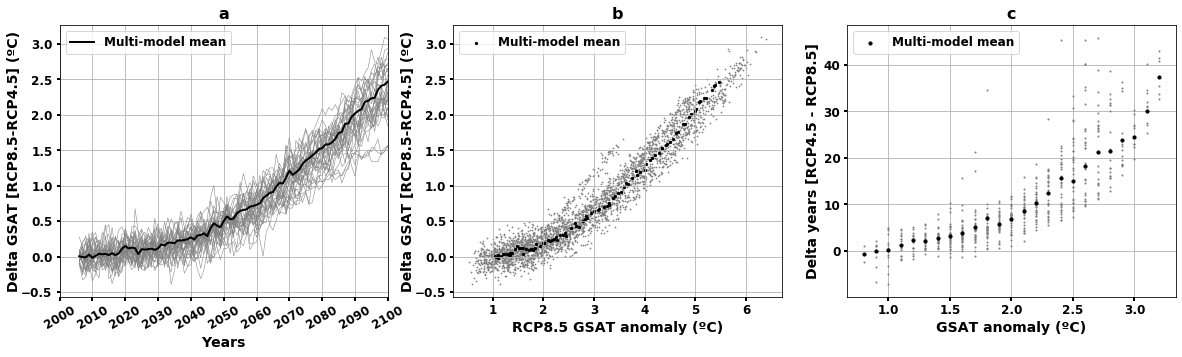

In [30]:
# == Delta GSAT as a function of (a) time and (b) warming ; and delta years as a function of GSAT anomaly (c) ==

fig,ax = plt.subplots(ncols=3,figsize=(20,5))

xGSAT_a = np.arange(0,5.01,0.1)
deltayears_mean = xr.DataArray(np.zeros((len(model_names),len(xGSAT_a))),dims=['models','GSAT_anom'],coords=[model_names,xGSAT_a])

for imod,model in enumerate(DGSAT_means.models):
    # Get data ready for panel c - smooth to make bijection GSAT(time)
    var45 = GSAT_45_a_all[imod]
    var85 = GSAT_h85_a_all[imod].sel(time=slice(2006,2100))
    var45_smooth = var45.rolling(time=20,center=True,min_periods=1).mean()
    var85_smooth = var85.rolling(time=20,center=True,min_periods=1).mean()
    time45 = xr.DataArray(np.zeros((len(var85_smooth.members),len(xGSAT_a))),dims=['members','GSAT_anom'],coords=[var85_smooth.members,xGSAT_a])
    time85 = xr.DataArray(np.zeros((len(var85_smooth.members),len(xGSAT_a))),dims=['members','GSAT_anom'],coords=[var85_smooth.members,xGSAT_a])
    for i,m in enumerate(DGSAT_all[imod].members):        
        # Panel a
        DGSAT_all[imod].sel(members=m).plot(ax=ax[0],color='grey',linewidth=0.5)
        # Panel b
        ax[1].scatter(GSAT_h85_a_all[imod].sel(time=slice(2006,2100),members=m),
                    DGSAT_all[imod].sel(members=m),color='grey',s=0.5)
        # Panel c - interpolate and plot
        time85[i,:] = np.interp(xGSAT_a,var85_smooth.sel(members=m).data,var85_smooth.time.data,left=np.nan,right=np.nan)
        time45[i,:] = np.interp(xGSAT_a,var45_smooth.sel(members=m).data,var85_smooth.time.data,left=np.nan,right=np.nan)
        deltayears = time45 - time85
        ax[2].scatter(xGSAT_a,deltayears[i,:],color='grey',s=1)
    deltayears_mean[imod,:] = deltayears.mean(dim='members')

DGSAT_means.mean(dim='models').plot(ax=ax[0],label='Multi-model mean',color='black',linewidth=2)
# DGSAT_means.median(dim='models').plot(ax=ax[0],label='Median of means',color='red',linewidth=2)
ax[0].legend(prop={'weight':'bold','size':12})
ax[0].set_ylabel('Delta GSAT [RCP8.5-RCP4.5] (ºC)',fontsize=14, fontweight='bold',labelpad=0)
ax[0].set_xlabel('Years',fontsize=14,fontweight='bold')
ax[0].grid()
ax[0].set_xticks(np.arange(2000,2101,10))
plt.setp(ax[0].get_xticklabels(),rotation=30)
ax[0].set_title('a',fontsize=16,fontweight='bold')
ax[0].set_xlim([2000,2100])

ylim = ax[0].get_ylim()
ax[1].scatter(GSAT_85_a_means.mean(dim='models'),DGSAT_means.mean(dim='models'),label='Multi-model mean',color='black',s=5)
# ax[1].scatter(GSAT_85_a_means.mean(dim='models'),DGSAT_means.median(dim='models'),label='Median of means',color='red',s=5)
ax[1].legend(prop={'weight':'bold','size':12})
ax[1].grid()
ax[1].set_ylim(ylim[0],ylim[1])
ax[1].set_ylabel('Delta GSAT [RCP8.5-RCP4.5] (ºC)',fontsize=14, fontweight='bold',labelpad=0)
ax[1].set_xlabel('RCP8.5 GSAT anomaly (ºC)',fontsize=14, fontweight='bold')
ax[1].set_title('b',fontsize=16,fontweight='bold')

ax[2].scatter(xGSAT_a,deltayears_mean.mean(dim='models'),color='black',s=10,label='Multi-model mean')
ax[2].legend(loc='upper left',prop={'weight':'bold','size':12})
ax[2].set_xlabel('GSAT anomaly (ºC)',fontsize=14, fontweight='bold')
ax[2].set_ylabel('Delta years [RCP4.5 - RCP8.5]',fontsize=14, fontweight='bold')
ax[2].grid()
ax[2].set_axisbelow(True)
ax[2].set_title('c',fontsize=16,fontweight='bold')

for ax in ax.ravel().tolist():
    ax.tick_params(axis='both', which='major', width=2)#, labelsize=12)
    plt.setp(ax.get_yticklabels(), fontweight='bold', fontsize=12)
    plt.setp(ax.get_xticklabels(), fontweight='bold', fontsize=12)
    
# plt.subplots_adjust(hspace=0.05)
# plt.suptitle('GSAT difference between RCP8.5 and RCP4.5 as a function of (a) time and (b) RCP8.5 GSAT anomaly \n for 10 models',fontsize=14)
plt.savefig('DeltaGSAT_deltayears_RCP45_RCP85.png',bbox_inches='tight',dpi=150)